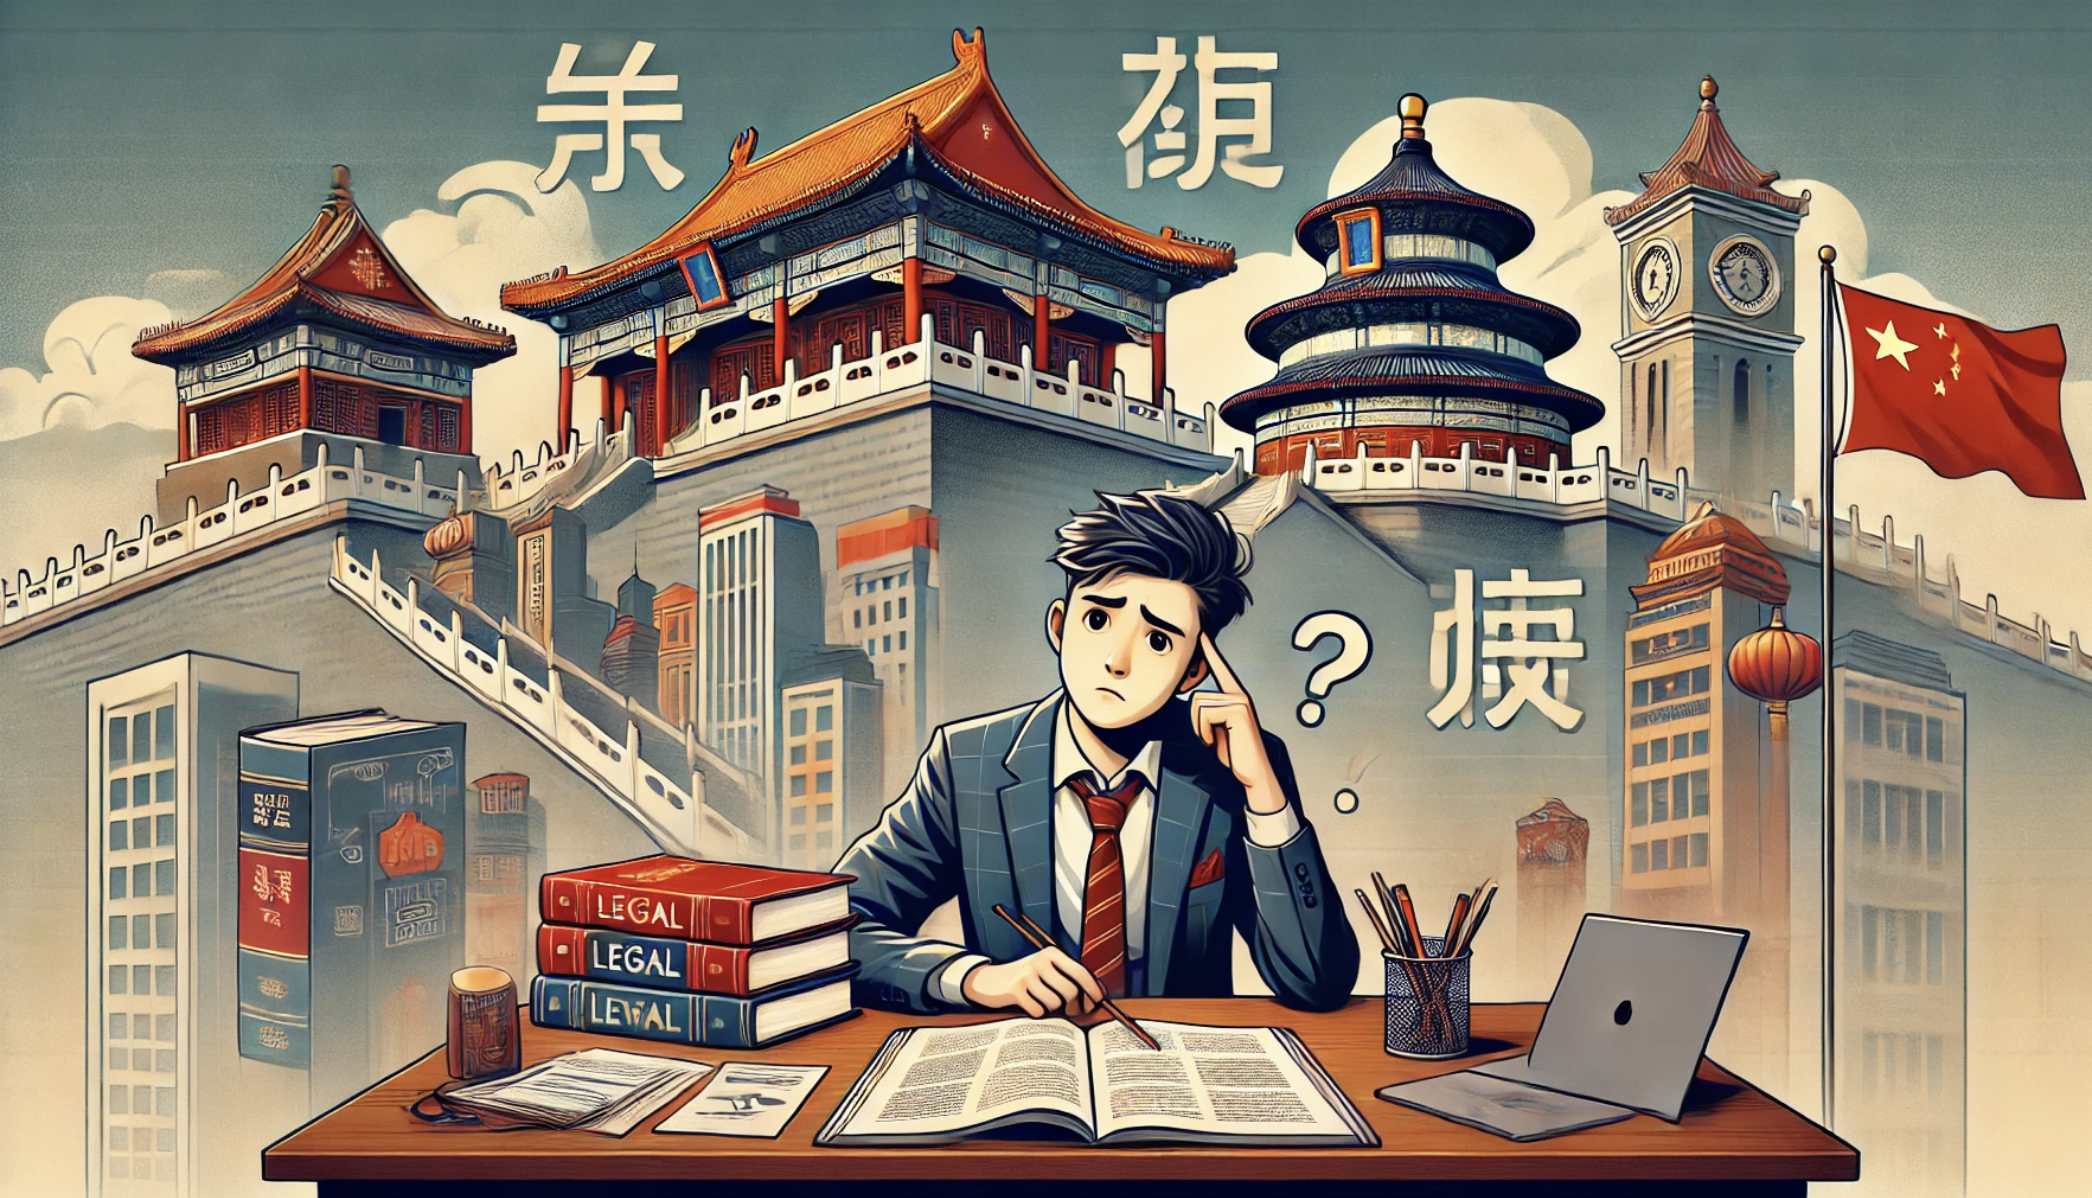

# Nekem ez kínai - RAG (Retrieval Augmented Generation)


Erasmus hallgatóként Kínában tanulsz, és éppen egy közgazdasági projekt feladatán dolgozol. A projekt témája egy új elektronikai eszköz gyártásával kapcsolatos startup költségtervezése. Ahogy számolod a költségeket, felmerül benned, hogy vannak-e különleges szabályozások, amelyeket a cégednek be kell tartania, például az elektronikai hulladék újrahasznosítására vonatkozóan. A probléma azonban az, hogy a törvények kínai nyelvűek, és te nem beszélsz kínaiul. Ezért a feladatod az, hogy egy AI-asszisztens segítségével megtaláld, milyen előírások vonatkoznak az elektronikai termékek gyártóira Kínában.

A BM25  egy jól bevált keresési algoritmus, amely kiemelkedő teljesítményt nyújt a dokumentumok relevanciájának mérésében. A RAG (Retrieval-Augmented Generation) rendszerben a BM25 kiválóan alkalmas a releváns szövegek megtalálására, mert figyelembe veszi:


*   a kulcsszavak előfordulási gyakoriságát (TF-IDF alapú számítás),
*   a dokumentum hossza és a kulcsszavak súlyozása közötti egyensúlyt.



Mivel a nagy nyelvi modellek többsége nem tud magyarul, így úgy döntöttél, hogy megkönnyíted a rendszer dolgát és angolul teszed fel a kérdést:

`query = "What is the requirement regarding recycling systems for electronic product manufacturers in order to achieve efficient recycling and recovery?"`

A feladat megoldása a modell válasza, azaz a `"The key requirements summarized in one sentence:"` utáni egy mondat, bulletpointok és lista számozások nélkül.

In [ ]:
%%capture
!pip install faiss-cpu datasets jieba rank_bm25
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

In [ ]:
from transformers import AutoTokenizer, pipeline
import torch
import jieba
from rank_bm25 import BM25Okapi
from datasets import load_dataset

In [ ]:
# A releváns törvények értelmezésében egy többnyelvű modell lesz a segítségedre:

model = "tiiuae/falcon-7b"

falcon_tokenizer = AutoTokenizer.from_pretrained(model)
falcon_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=falcon_tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

#Idáig futtasd le a forduló elején!
-----------------------------------

#... a feladat


In [ ]:

dataset = load_dataset("PandaVT/chinese_law_examples")
chinese_law_examples = [example['contents'] for example in dataset['train']]
query = "What is the requirement regarding recycling systems for electronic product manufacturers in order to achieve efficient recycling and recovery?"

# Töltsd be a Helsinki Marian angol-kínai fordító modellt és a hozzá tartozó tokenizert! (Tipp: https://huggingface.co/Helsinki-NLP/opus-mt-en-zh)
helsinki_model_name = 'Helsinki-NLP/opus-mt-en-zh'
translation_pipeline = pipeline("translation", model=helsinki_model_name)

def translate_query_to_chinese(query):
    # Írd meg az angol-kínai fordító függvényt a betöltött pipeline segítségével! Figyelj, hogy a függvény egy stringgel térjen vissza!
    translated_query = translation_pipeline(query)
    print(translated_query)
    return translated_query[0]['translation_text']


# Fordítsd le az angol nyelvű keresésed kínai nyelvre, hogy össze tudd hasonlítani a törvénygyűjteménnyel:
translated_query = translate_query_to_chinese(query)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'translation_text': '关于电子产品制造商回收系统以实现有效回收和回收的要求是什么?'}]


In [ ]:
from rank_bm25 import BM25Okapi
# Kínai szövegek tokenizálása a releváns törvények megtalálásáhz:
tokenized_docs = [list(jieba.cut(doc)) for doc in chinese_law_examples]
tokenized_query = list(jieba.cut(translated_query))

# Pontozd a törvényeket a BM25 algoritmussal! - Tipp: https://pypi.org/project/rank-bm25/
bm25 = BM25Okapi(tokenized_docs)
doc_scores = bm25.get_scores(tokenized_query)


# Választ ki a két legrelevánsabb törvényt!
relevant_docs = bm25.get_top_n(tokenized_query, chinese_law_examples, n=2)
context = " ".join([doc for doc in relevant_docs])
print(context)

第六十六条国家建立电器电子、铅蓄电池、车用动力电池等产品的生产者责任延伸制度。电器电子、铅蓄电池、车用动力电池等产品的生产者应当按照规定以自建或者委托等方式建立与产品销售量相匹配的废旧产品回收体系，并向社会公开，实现有效回收和利用。国家鼓励产品的生产者开展生态设计，促进资源回收利用。 第六十七条国家对废弃电器电子产品等实行多渠道回收和集中处理制度。禁止将废弃机动车船等交由不符合规定条件的企业或者个人回收、拆解。拆解、利用、处置废弃电器电子产品、废弃机动车船等，应当遵守有关法律法规的规定，采取防止污染环境的措施。


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What is the requirement regarding recycling systems for electronic product manufacturers in order to achieve efficient recycling and recovery?
The European Union (EU) has set a target of 65% recycling rate for electrical and electronic equipment (EEE) by 2016. The EU has also set a target of 85% recycling rate for WEEE by 2016.
The EU has also set a target of 85% recycling rate for WEEE by 2016.
The EU has set a target of 65% recycling rate for EEE by 2016.
The EU has set a target of 85% recycling rate for WEEE by 2016.
The EU has set a target of 65% recycling rate for EEE by 2016.
The EU has set a target of 85% recycling rate for WEEE by 2016.
The EU has set a target of 65% recycling rate for EEE by 2016.


In [ ]:
# Ahhoz, hogy a falcon-7b modell válaszoljon a kérdésedre, szüksége lesz a releváns törvényekre,
# a kérdésre, valamint egy kis iránymutatásra is, hogy milyen formában válaszoljon:

input_text = (f"Context: {context}\n\n Question: {query}\n\n The key requirements summarized in one sentence:")

generated_text = falcon_pipeline(
    input_text,
    max_new_tokens=30,
    num_beams=3,
    no_repeat_ngram_size=1,
    early_stopping=True
)


print("Generated text:", generated_text[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text: Context: 第六十六条国家建立电器电子、铅蓄电池、车用动力电池等产品的生产者责任延伸制度。电器电子、铅蓄电池、车用动力电池等产品的生产者应当按照规定以自建或者委托等方式建立与产品销售量相匹配的废旧产品回收体系，并向社会公开，实现有效回收和利用。国家鼓励产品的生产者开展生态设计，促进资源回收利用。 第六十七条国家对废弃电器电子产品等实行多渠道回收和集中处理制度。禁止将废弃机动车船等交由不符合规定条件的企业或者个人回收、拆解。拆解、利用、处置废弃电器电子产品、废弃机动车船等，应当遵守有关法律法规的规定，采取防止污染环境的措施。

 Question: What is the requirement regarding recycling systems for electronic product manufacturers in order to achieve efficient recycling and recovery?

 The key requirements summarized in one sentence:

 (1) Manufacturers of electrical products, lead-acid storage batteries or motor vehicles shall establish a waste management system that matches their sales volume. They
